In [1]:
import os
import pandas as pd
import glob
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor, Lambda, Compose, Resize, Normalize, Grayscale
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image 
import numpy as np

In [2]:
liste_path = glob.glob('data/dataset/*/*', recursive=True)

In [3]:
len(liste_path)

7750

In [4]:
labels = [path.split(os.sep)[-2] for path in liste_path]
image_names = [path.split(os.sep)[-1] for path in liste_path]

In [5]:
df = pd.DataFrame({'image_name': image_names, 'label': labels})
df = df.sample(frac = 1)
df

,image_name,label
141,62365.jpg,7
6699,40317.jpg,9
4706,3290.jpg,div
5065,9117.jpg,div
6649,2661.jpg,5
...,...,...
7713,44807.jpg,3
4165,56564.jpg,0
4893,7172.jpg,div
1850,7223.jpg,add


In [6]:
label_liste = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'add', 'div', 'mul', 'sub']

In [7]:
def calculate_mean_and_std_for_images(df):
    means = []
    sqds = []
    for index, row in df.iterrows():
        path = os.path.join("data/dataset/", row['label'], row['image_name'])
        image = Image.open(path).convert('L')
        image = image.resize((28,28))
        image = np.array(image)
        means.append(np.mean(image))
        sqds.append(np.std(image))

    # Calculate the mean
    mean = np.mean(means, axis=0)

    # Calculate the sum of squared differences (Sqd)
    sqd = np.mean(sqds, axis=0)

    return mean, sqd

In [8]:
calculate_mean_and_std_for_images(df)

(240.34469684002633, 47.712887672203195)

In [9]:
class ExpandedMNIST(Dataset):
    def __init__(self, dir, df, label, transform=None):
        self.dir = dir
        self.df = df
        self.transform = transform
        self.label = label
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        image_name = self.df.iloc[idx, 0]
        label_name = self.df.iloc[idx, 1]
        image = Image.open(os.path.join(self.dir, label_name, image_name)).convert('L')
        image = image.resize((28,28))
        image = np.array(image)
        image = 255 - image
        
        label_idx = self.label.index(label_name)
        if self.transform is not None:
            image = self.transform(image)
        return image, label_idx

In [10]:
transform = Compose([ToTensor()])

In [11]:
train_dataset = ExpandedMNIST('data/dataset', df[:int(len(df) * 0.8)], label_liste, transform=transform)
test_dataset = ExpandedMNIST('data/dataset', df[int(len(df) * 0.8):], label_liste,transform=transform)

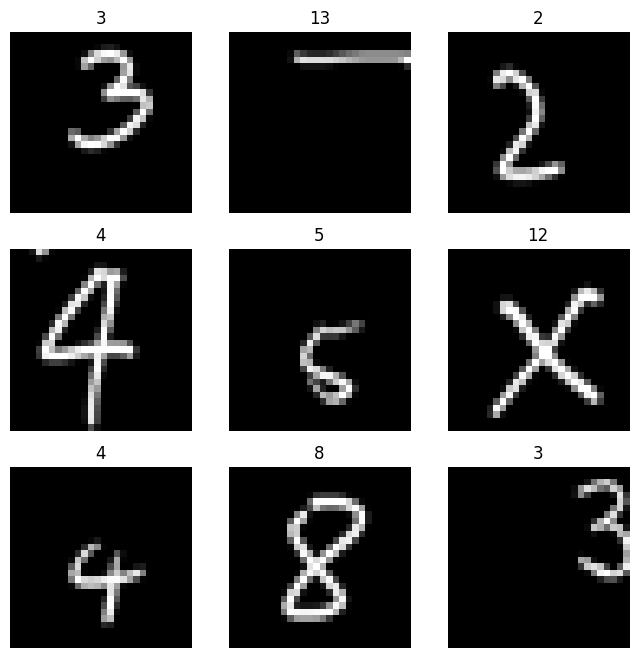

In [13]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [13]:
train_dataloader = DataLoader(train_dataset, batch_size=64, num_workers=4,shuffle=True, drop_last=True, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, num_workers=4, shuffle=False, drop_last=False, pin_memory=True)

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])
tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0

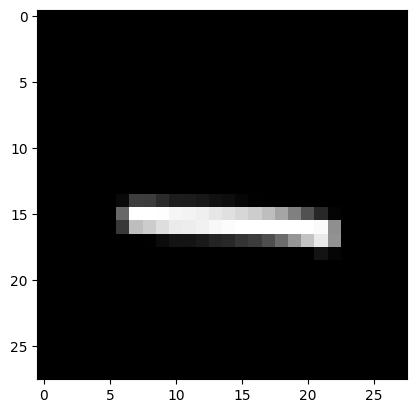

Label: 13


In [14]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
print(img)
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [15]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            #1, 28,28
            nn.Conv2d(1, 8, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),

            #4, 14, 14

            nn.Conv2d(8, 16, kernel_size=5),
            nn.ReLU(inplace=True),
        )
        self.mlp = nn.Sequential(
            nn.Flatten(),
            nn.Linear(9216, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, len(label_liste))
        )
    def forward(self, x):
        x = self.conv1(x)
        logits = self.mlp(x)
        return logits

In [16]:
device = "cuda"
model = CNN().to(device)
print(model)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
    (3): ReLU(inplace=True)
  )
  (mlp): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=9216, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=512, out_features=128, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.2, inplace=False)
    (7): Linear(in_features=128, out_features=14, bias=True)
  )
)


In [17]:
learning_rate = 1e-3
batch_size = 64
epochs = 5

In [18]:
def train_loop(dataloader, model, loss_fn, optimizer, scheduler):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    with tqdm(dataloader, desc="Training") as pbar:
        for X, y in pbar:
            X, y = X.to(device), y.to(device)
            # Compute prediction and loss
            pred = model(X)
            loss = loss_fn(pred, y)

            # Backpropagation
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            pbar.set_postfix(loss=f"{loss.item():2e}")
        scheduler.step()


def test_loop(dataloader, model, loss_fn, logs):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        with tqdm(dataloader, desc="Testing") as pbar:
            for X, y in pbar:
                X, y = X.to(device), y.to(device)
                pred = model(X)
                test_loss += loss_fn(pred, y).item()
                correct += (pred.argmax(1) == y).type(torch.float).sum().item()
                pbar.set_postfix(loss=f"{test_loss/num_batches:>8f}", accuracy=f"{correct/size * 100:0.1f}")
                logs["preds"]+=pred.argmax(1).cpu().numpy().tolist()
                logs["labels"]+=y.cpu().numpy().tolist()

In [19]:
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
logs = {
    "preds": [],
    "labels": [],
}
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer, lr_scheduler)
    test_loop(test_dataloader, model, loss_fn, logs)
print("Done!")

Epoch 1
-------------------------------


Testing: 100%|██████████| 25/25 [00:00<00:00, 95.71it/s, accuracy=63.2, loss=1.109528]


Epoch 2
-------------------------------


Testing: 100%|██████████| 25/25 [00:00<00:00, 94.60it/s, accuracy=80.3, loss=0.598166]


Epoch 3
-------------------------------


Testing: 100%|██████████| 25/25 [00:00<00:00, 97.61it/s, accuracy=87.9, loss=0.387835]


Epoch 4
-------------------------------


Testing: 100%|██████████| 25/25 [00:00<00:00, 93.40it/s, accuracy=88.8, loss=0.350393]


Epoch 5
-------------------------------


Testing: 100%|██████████| 25/25 [00:00<00:00, 98.89it/s, accuracy=91.1, loss=0.294172]


Epoch 6
-------------------------------


Testing: 100%|██████████| 25/25 [00:00<00:00, 100.08it/s, accuracy=91.1, loss=0.294172]


Epoch 7
-------------------------------


Testing: 100%|██████████| 25/25 [00:00<00:00, 101.59it/s, accuracy=91.9, loss=0.273888]


Epoch 8
-------------------------------


Testing: 100%|██████████| 25/25 [00:00<00:00, 102.53it/s, accuracy=91.0, loss=0.274785]


Epoch 9
-------------------------------


Testing: 100%|██████████| 25/25 [00:00<00:00, 104.06it/s, accuracy=91.5, loss=0.269161]


Epoch 10
-------------------------------


Testing: 100%|██████████| 25/25 [00:00<00:00, 90.79it/s, accuracy=92.6, loss=0.253790]

Done!


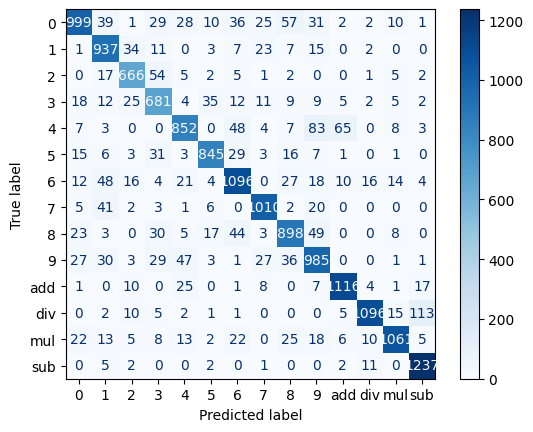

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
conf_mat = confusion_matrix(logs["labels"], logs["preds"])
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=label_liste)
disp.plot(cmap=plt.cm.Blues, values_format="d")

In [21]:
torch.save(model.state_dict(), 'data/checkpoint/cnn_custom_weights.pth')

In [22]:
model = CNN()
model.load_state_dict(torch.load('data/checkpoint/cnn_custom_weights.pth'))
model.eval()

torch.onnx.export(model, 
                torch.randn(1, 1, 28, 28), 
                'docs/static/model//cnn_custom.onnx', 
                do_constant_folding=True,
                export_params=True,
                opset_version=10, 
                input_names=['image'], 
                output_names=['preds'],
                verbose=True
                )

Exported graph: graph(%image : Float(1, 1, 28, 28, strides=[784, 784, 28, 1], requires_grad=0, device=cpu),
      %conv1.0.weight : Float(8, 1, 5, 5, strides=[25, 25, 5, 1], requires_grad=1, device=cpu),
      %conv1.0.bias : Float(8, strides=[1], requires_grad=1, device=cpu),
      %conv1.2.weight : Float(16, 8, 5, 5, strides=[200, 25, 5, 1], requires_grad=1, device=cpu),
      %conv1.2.bias : Float(16, strides=[1], requires_grad=1, device=cpu),
      %mlp.1.weight : Float(512, 9216, strides=[9216, 1], requires_grad=1, device=cpu),
      %mlp.1.bias : Float(512, strides=[1], requires_grad=1, device=cpu),
      %mlp.4.weight : Float(128, 512, strides=[512, 1], requires_grad=1, device=cpu),
      %mlp.4.bias : Float(128, strides=[1], requires_grad=1, device=cpu),
      %mlp.7.weight : Float(14, 128, strides=[128, 1], requires_grad=1, device=cpu),
      %mlp.7.bias : Float(14, strides=[1], requires_grad=1, device=cpu)):
  %/conv1/conv1.0/Conv_output_0 : Float(1, 8, 28, 28, strides=[6272,